<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> <h1>CoVID-19</h1>
<h1>Visualizing individual patient data</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

from collections import Counter

import wget
import os

from mpl_toolkits.basemap import Basemap
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

pandas    1.0.1
wget      3.2
autopep8  1.5
watermark 2.0.2
numpy     1.18.1
json      2.0.9
Sun Jun 14 2020 

CPython 3.7.3
IPython 6.2.1

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.5.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : 8f3de1773cbcd0ebcb3b2c037546e68cdd686f9b


Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Patient data

The file stored in the original github repository is continuously updated

In [4]:
url = 'https://raw.githubusercontent.com/beoutbreakprepared/nCoV2019/master/latest_data/'
file = 'latestdata.tar.gz'

Check that we have a copy or download it if we dont

In [5]:
if not os.path.exists('data/' + file):
    print('Downloading file...', end='')
    fp = wget.download(url + file, 'data/' + file)
    print("DONE")

Load the file using pandas

In [6]:
data = pd.read_csv('data/' + file, parse_dates=False, dtype='str',
                  usecols=['latitude', 'longitude', 'country', 'sex', 'age', 'date_confirmation', 'date_onset_symptoms'])

The file has a [long list of fields](https://www.nature.com/articles/s41597-020-0448-0), but only a few are useful for our purposes, so we load only those to save memory. In total we have information on over 2.3 Millions patients

In [7]:
data.shape

(2310112, 7)

## Geographical Distribution

In [8]:
counts = np.zeros((180, 360), dtype='float')
data['y'] = np.round(data['longitude'].astype('float')+180)
data['x'] = np.round(data['latitude'].astype('float')+90)
coords = data[['x', 'y']].dropna().copy()
coords['count'] = 1

coords = coords.groupby(['x', 'y'], as_index=False).sum()

for i, row in coords.iterrows():
    x = int(row.x)
    y = int(row.y)
    count = row['count']
    
    counts[x, y] = count

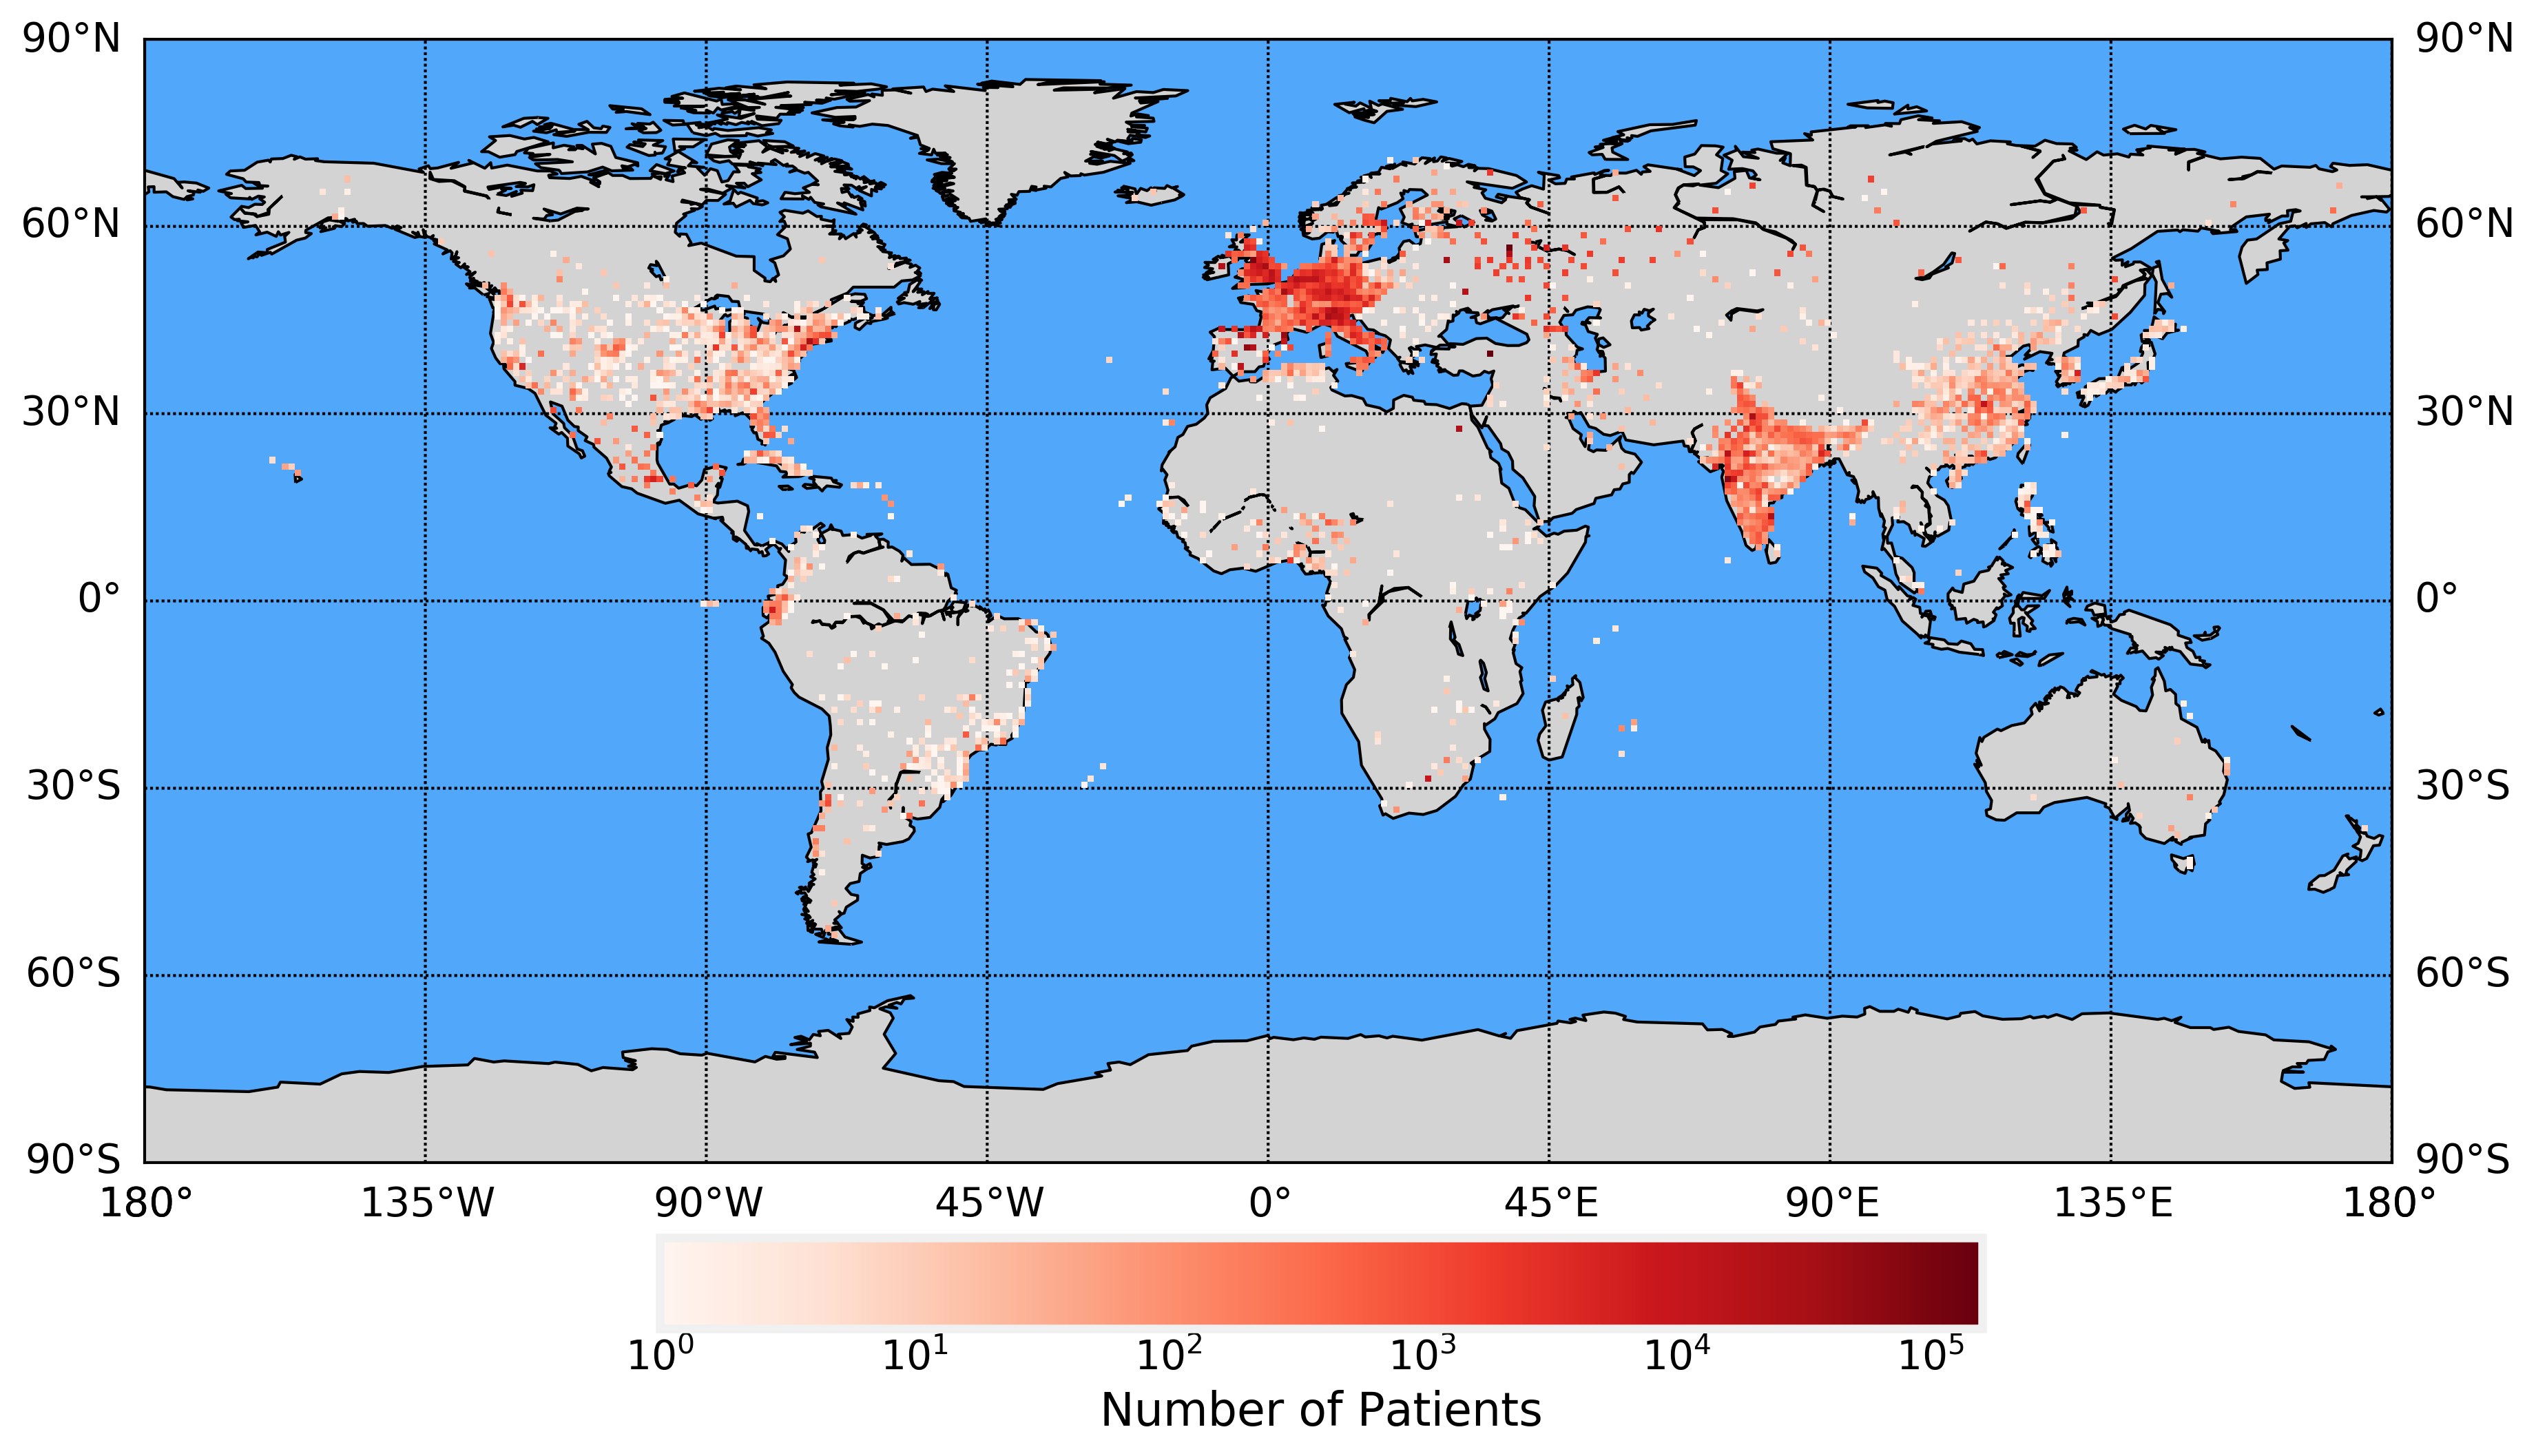

In [9]:
fig, ax = plt.subplots(1)

m = Basemap(ax=ax)
m.drawmapboundary(fill_color=colors[0])
m.fillcontinents(color='lightgray',lake_color=colors[0])
m.drawcoastlines()

m.drawparallels(np.arange(-90, 90.5, 30), labels=[1,1,0,1], fontsize=14)
m.drawmeridians(np.arange(-180, 180, 45), labels=[1,1,0,1], fontsize=14)

vmin = np.log10(counts+1).min()
vmax = np.log10(counts+1).max()
norm = Normalize(vmin=vmin, vmax=vmax)

counts[counts==0] = np.nan

m.imshow(np.log10(counts+1), cmap=plt.cm.Reds, zorder=3)

cax = fig.add_axes([0.27, 0.1, 0.5, 0.05])

cb = ColorbarBase(cax, cmap=plt.cm.Reds, orientation='horizontal', norm=norm)
cb.ax.set_xticklabels([r'$10^0$', r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$', r'$10^5$'], fontsize=14)
cb.ax.set_xlabel('Number of Patients', fontsize=16)
fig.tight_layout()

## Country statistics

Count how many patients we have per country

In [10]:
country_counts = pd.DataFrame(Counter(data['country']).items(), columns=['Country', 'Patient_Count'])
country_counts.sort_values('Patient_Count', ascending=True, inplace=True)

In [11]:
country_age_counts = pd.DataFrame(Counter(data[['country', 'age']].dropna()['country']).items(), columns=['Country', 'Age_Count'])
country_age_counts.sort_values('Age_Count', ascending=True, inplace=True)

In [12]:
country_stats = country_counts.merge(country_age_counts, how='left').fillna(0)

Select only countries with more than 1000 patients

In [13]:
country_stats = country_stats[country_stats.Patient_Count > 1000]

Visualize the histogram

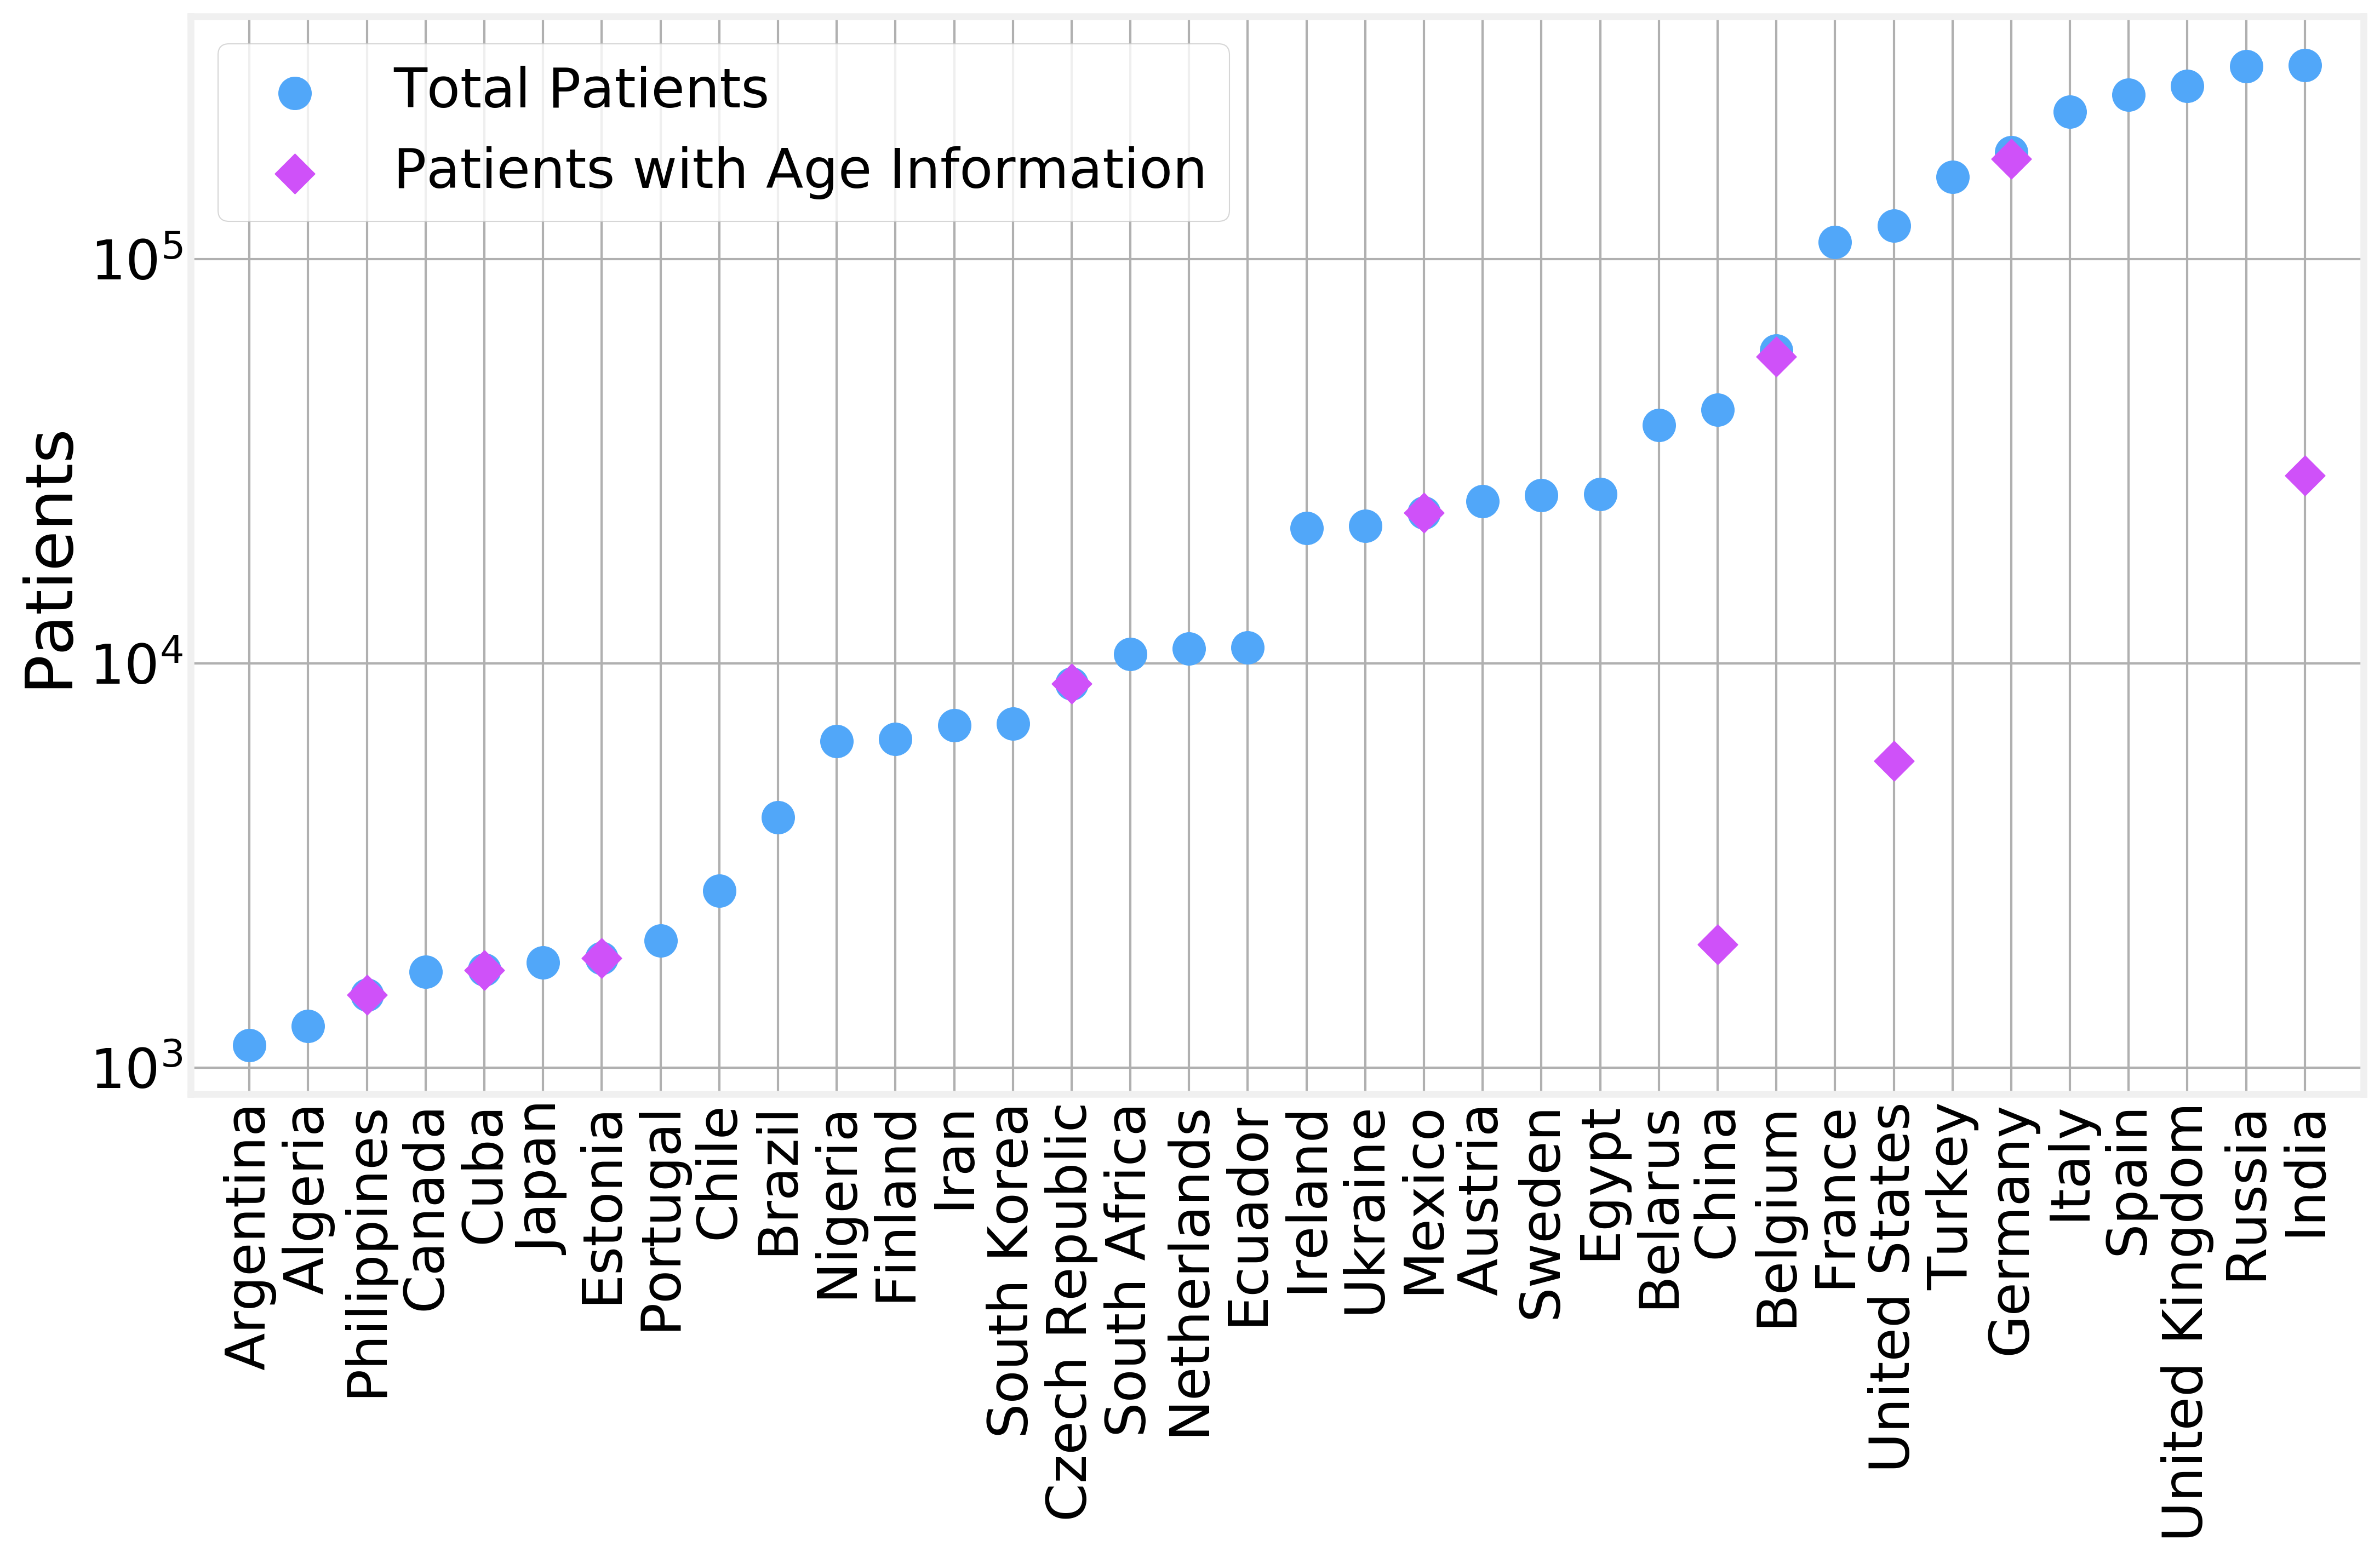

In [14]:
fig, ax = plt.subplots(1, figsize=(15,10))
ax.scatter(y=country_stats['Patient_Count'], x=np.arange(36), s=200, marker='o')
ax.scatter(y=country_stats['Age_Count'], x=np.arange(36), s=150, marker='D')
ax.set_xticks(np.arange(36))
ax.set_xticklabels(country_stats['Country'], rotation=90)
ax.set_yscale('log')
ax.set_xlim(-1, 36)
ax.set_ylabel('Patients')
ax.legend(['Total Patients', 'Patients with Age Information'])
fig.tight_layout()

## Delay between symptoms and case confirmation

The most interesting piece of information for each case is the date of onset of symptoms and the date when the case was first confirmed with rt-PCR. We parse the dates

In [15]:
data['date_onset_symptoms'] = pd.to_datetime(data['date_onset_symptoms'],  errors='coerce', format='%d.%m.%Y')
data['date_confirmation'] = pd.to_datetime(data['date_confirmation'], errors='coerce', format='%d.%m.%Y')

And clean up the dataset to keep only the instances where confirmation occurs after symptom onset

In [16]:
dates = data.dropna()
dates = dates[dates['date_confirmation'] > dates['date_onset_symptoms']].copy()
dates['count'] = 1

Of the original 2.3 million patients, we have symptom onset date and case confirmation dates for about 9%

In [17]:
dates.shape

(136141, 10)

With a significantly biased distribution across countries

In [18]:
dates[['country', 'count']].groupby('country').sum().sort_values('count', ascending=False).head(10)

,count
country,
Germany,110762
Mexico,23123
China,910
Japan,504
Singapore,282
Cuba,201
South Korea,86
Philippines,79
Brazil,46


We tabulate the distribution of symptom onset for each case confirmation date

In [19]:
date_counts = pd.pivot_table(dates, columns='date_onset_symptoms', 
                              index='date_confirmation', 
                              values='count', aggfunc='sum')

Make sure we have a continuous range of dates

In [20]:
date_counts = date_counts.resample('D').sum()
date_counts = date_counts.T.resample('D').sum().T

Replace zeros with NaN for transparency

In [21]:
date_counts[date_counts==0] = np.nan

Generate the matrix plot

Text(0, 0.5, 'Case Confirmation')

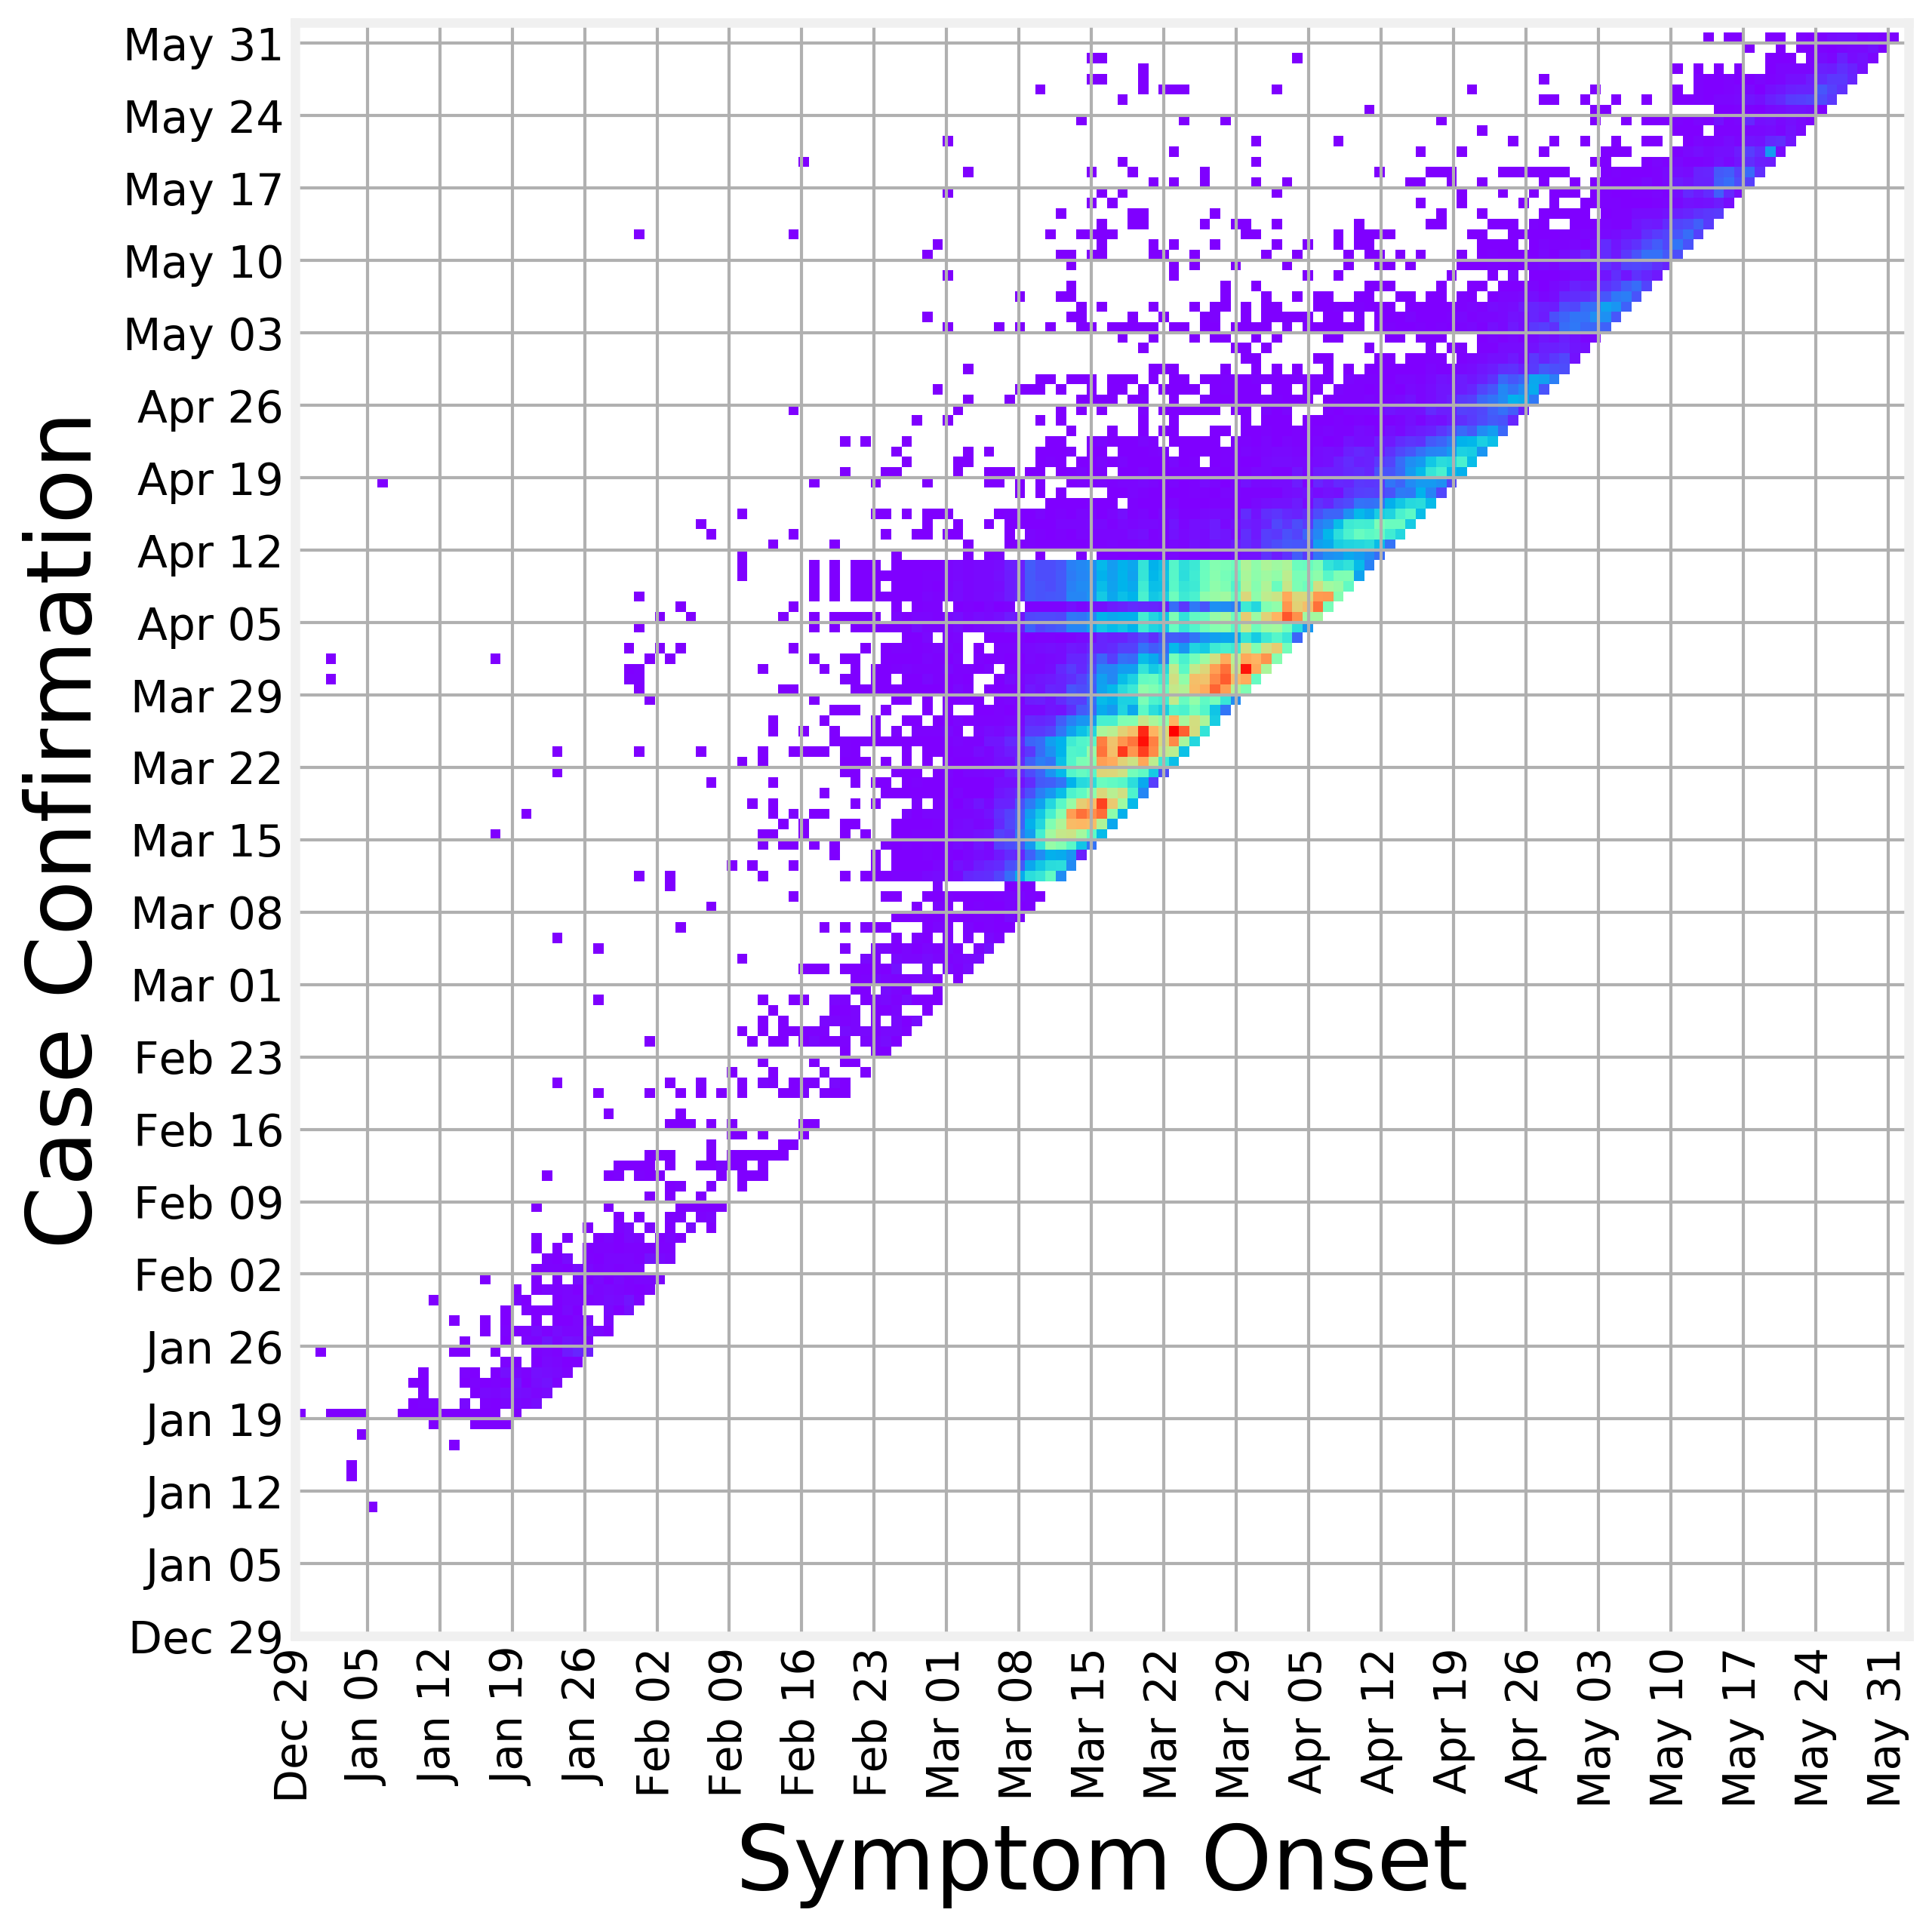

In [22]:
fig, ax = plt.subplots(1)

date_labels = [day.strftime('%b %d') for day in list(date_counts.columns)]

xlim, ylim = date_counts.shape
ax.imshow(date_counts.values, cmap=plt.cm.rainbow, origin='lower', extent=(0, 155, 12, 155))
ax.set_ylim(0, ylim)
ax.set_xlim(0, ylim)
ax.set_xticks(np.arange(0, ylim, 7))
ax.set_xticklabels(date_labels[::7], rotation=90, fontsize=14)
ax.set_yticks(np.arange(0, ylim, 7))
ax.set_yticklabels(date_labels[::7], fontsize=14)
ax.set_xlabel('Symptom Onset')
ax.set_ylabel('Case Confirmation')

## Age Group Analysis

Germany is the country with the most complete information. So we'll use it to look for any changes in behavior due to age group or gender

In [23]:
germany = dates[dates['country'] == 'Germany'].copy()

Clean up the age field

In [24]:
age_groups = pd.read_csv('data/age_groups.csv')
germany['age_group'] = germany['age'].map(dict(age_groups.values))
germany = germany[germany['age_group'] != 'NaN'].copy()

We have several thousand cases for each of our 6 age groups

In [25]:
germany['age_group'].value_counts().sort_index()

00-04      919
05-14     2165
15-34    28275
35-59    49000
60-79    20855
80+       9546
Name: age_group, dtype: int64

In [26]:
germany_clean = germany[['age_group', 'sex', 'date_onset_symptoms', 'date_confirmation']].dropna()

In [27]:
germany_clean['delta'] = germany_clean['date_confirmation']-germany_clean['date_onset_symptoms']
germany_clean['counts'] = 1

In [28]:
germany_counts = germany_clean[['age_group', 'sex', 'delta', 'counts']]\
.groupby(['age_group', 'sex', 'delta'], as_index=False).sum()

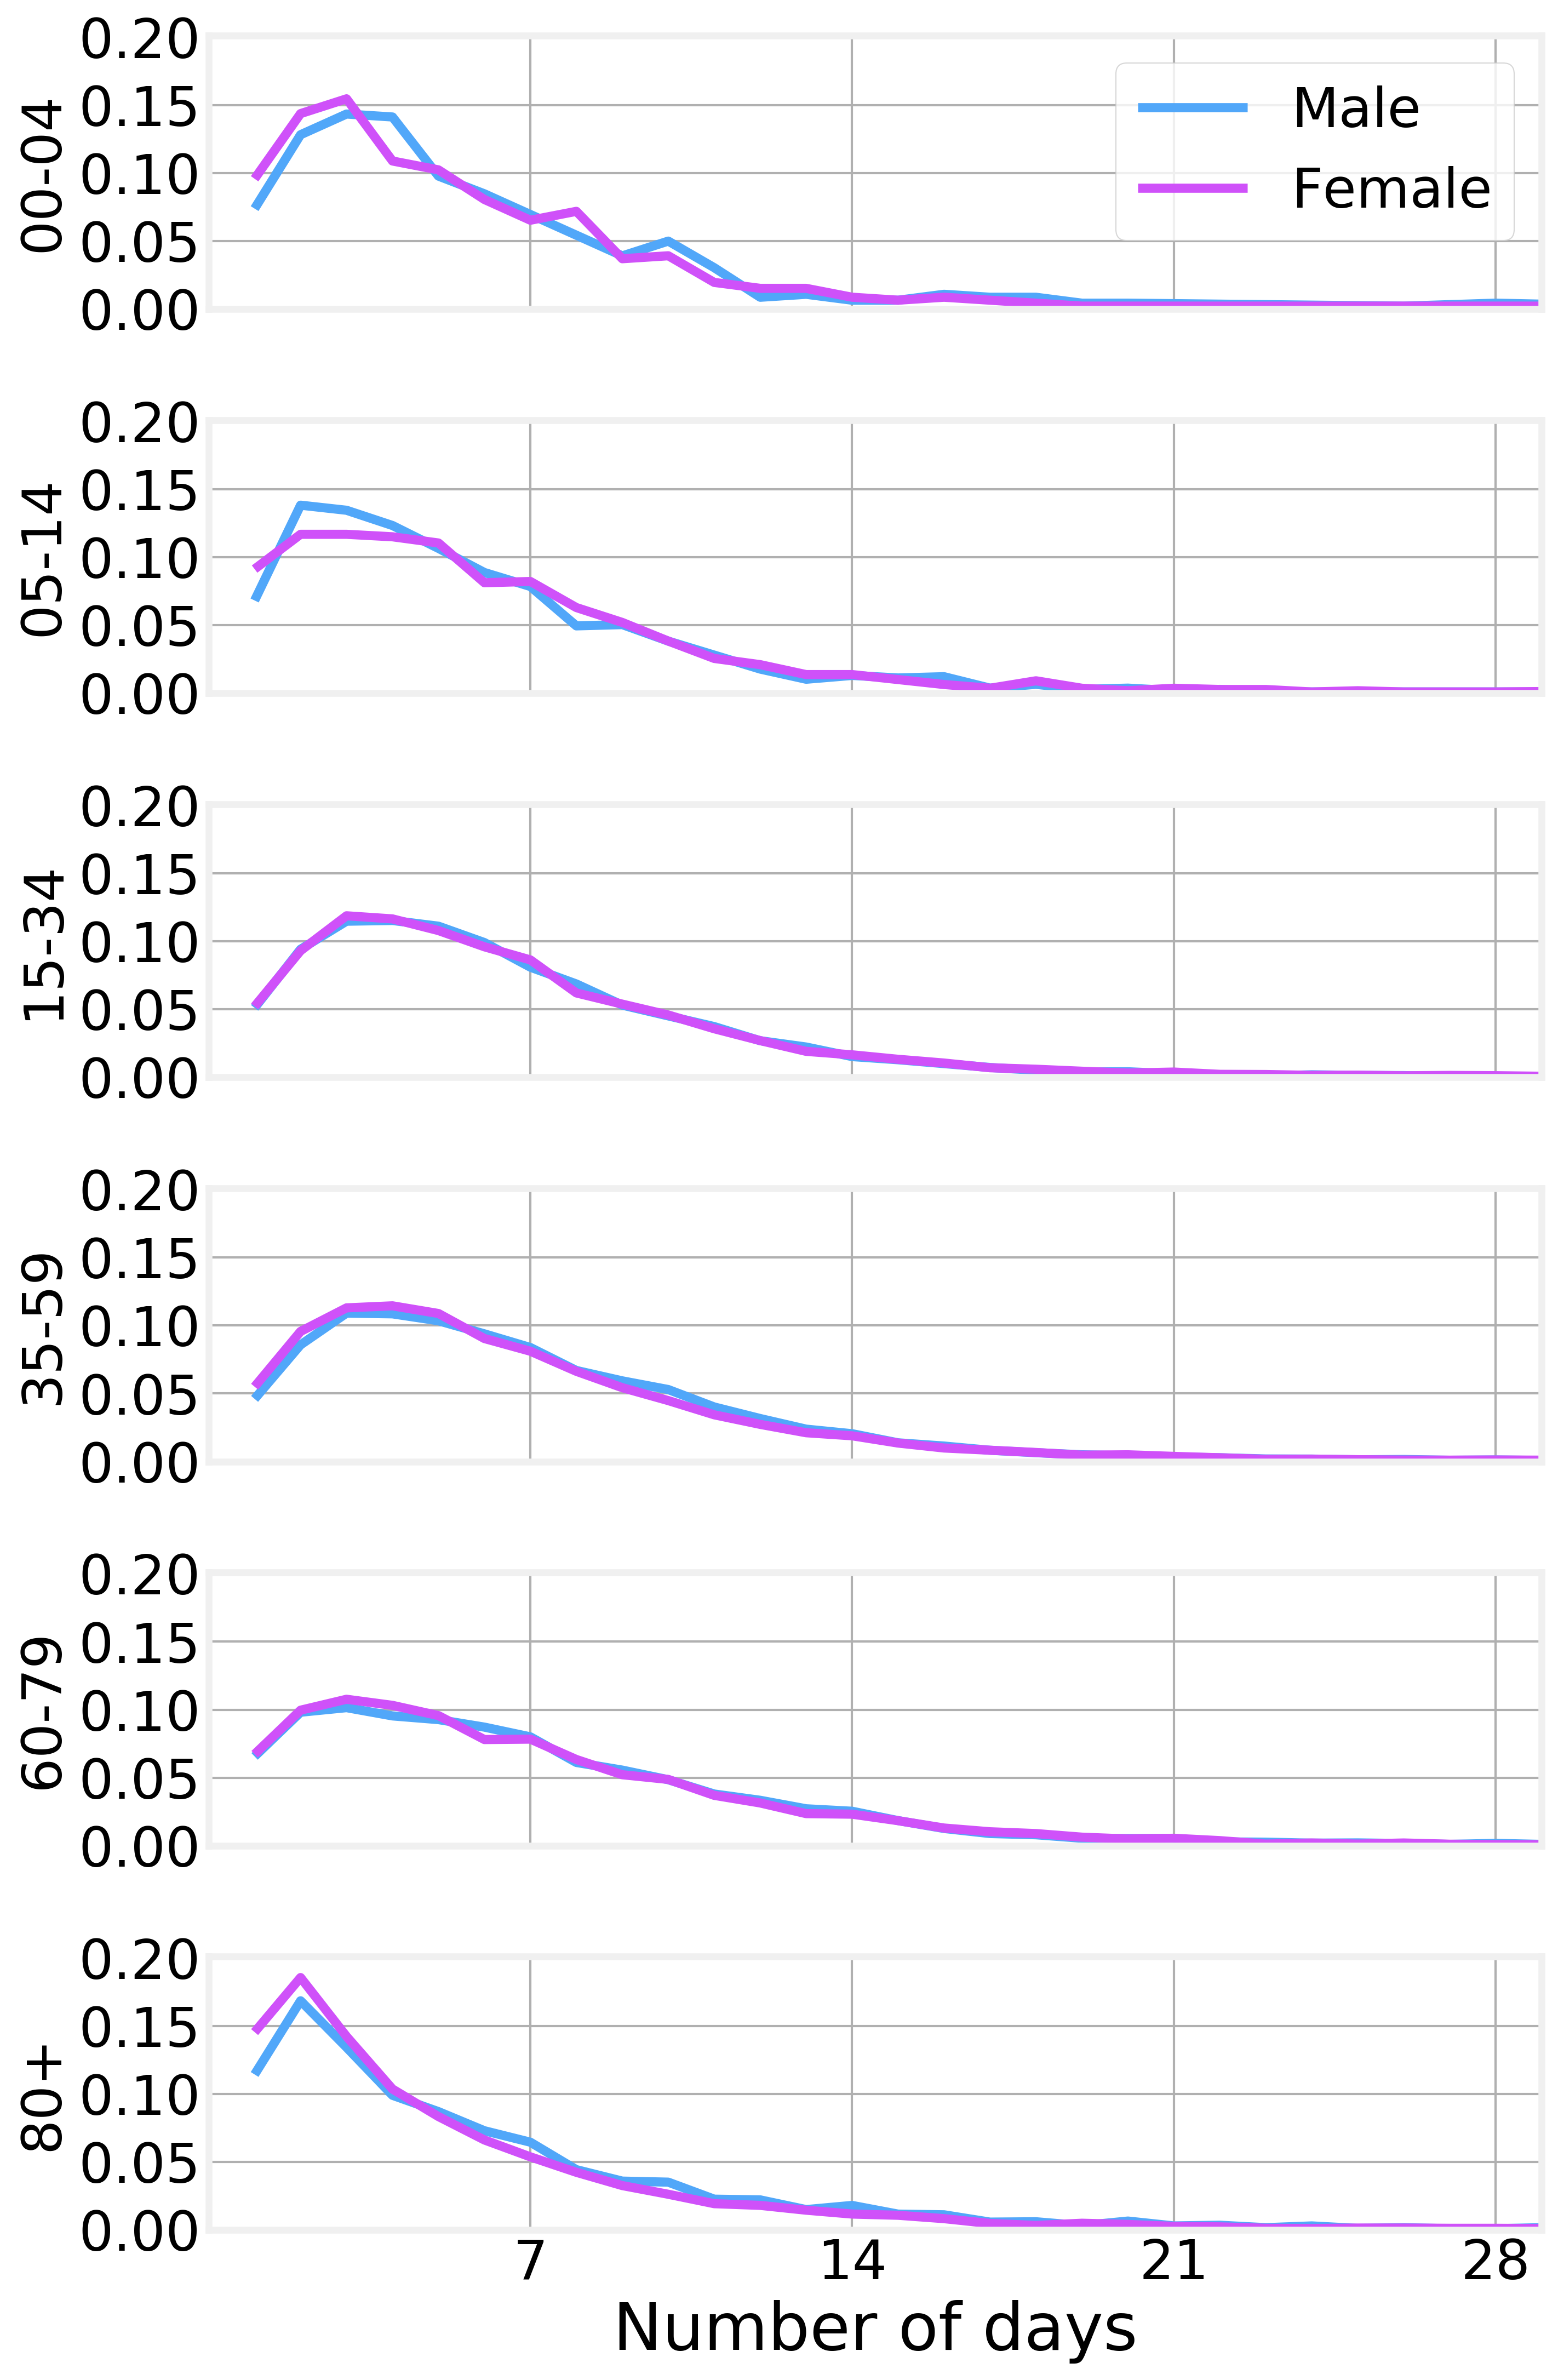

In [29]:
fig, ax_lst = plt.subplots(6, 1, sharex=True, sharey=True, figsize=(10, 15))

ages = ['00-04', '05-14', '15-34', '35-59', '60-79', '80+']
genders = ['male', 'female']

for i, age in enumerate(ages):
    for j, gender in enumerate(genders):
        current = germany_counts[(germany_counts['age_group'] == age) & (germany_counts['sex'] == gender)].copy()
        current = current.sort_values('delta')
        ax_lst[i].plot(current['delta'].dt.days, (current['counts']/current['counts'].sum()))
    
    ax_lst[i].set_ylabel(age, fontsize=24)

ax_lst[-1].set_xlabel('Number of days')
ax_lst[0].set_xlim(0, 29)
ax_lst[0].set_ylim(0, 0.201)
ax_lst[0].set_xticks([7, 14, 21, 28])
ax_lst[0].set_yticks([0, 0.05, 0.10, 0.15, 0.20])
ax_lst[0].legend(['Male', 'Female'], loc='upper right')
fig.tight_layout()

## Average behavior across all cases

In [30]:
germany_mean = germany_clean[['delta', 'counts']].groupby('delta', as_index=False).sum()
germany_mean['delay'] = germany_mean.delta.dt.days

In [31]:
germany_mean

,delta,counts,delay
0,1 days,6850,1
1,2 days,11273,2
2,3 days,12666,3
3,4 days,12163,4
4,5 days,11404,5
...,...,...,...
80,91 days,1,91
81,93 days,1,93
82,95 days,1,95
83,104 days,1,104


In [32]:
germany_delay = germany_mean[['delay', 'counts']].set_index('delay').sort_index()
new_range = np.arange(0, germany_delay.index.max()+1)
germany_delay = germany_delay.reindex(new_range, fill_value=0)
germany_delay /= germany_delay.sum()

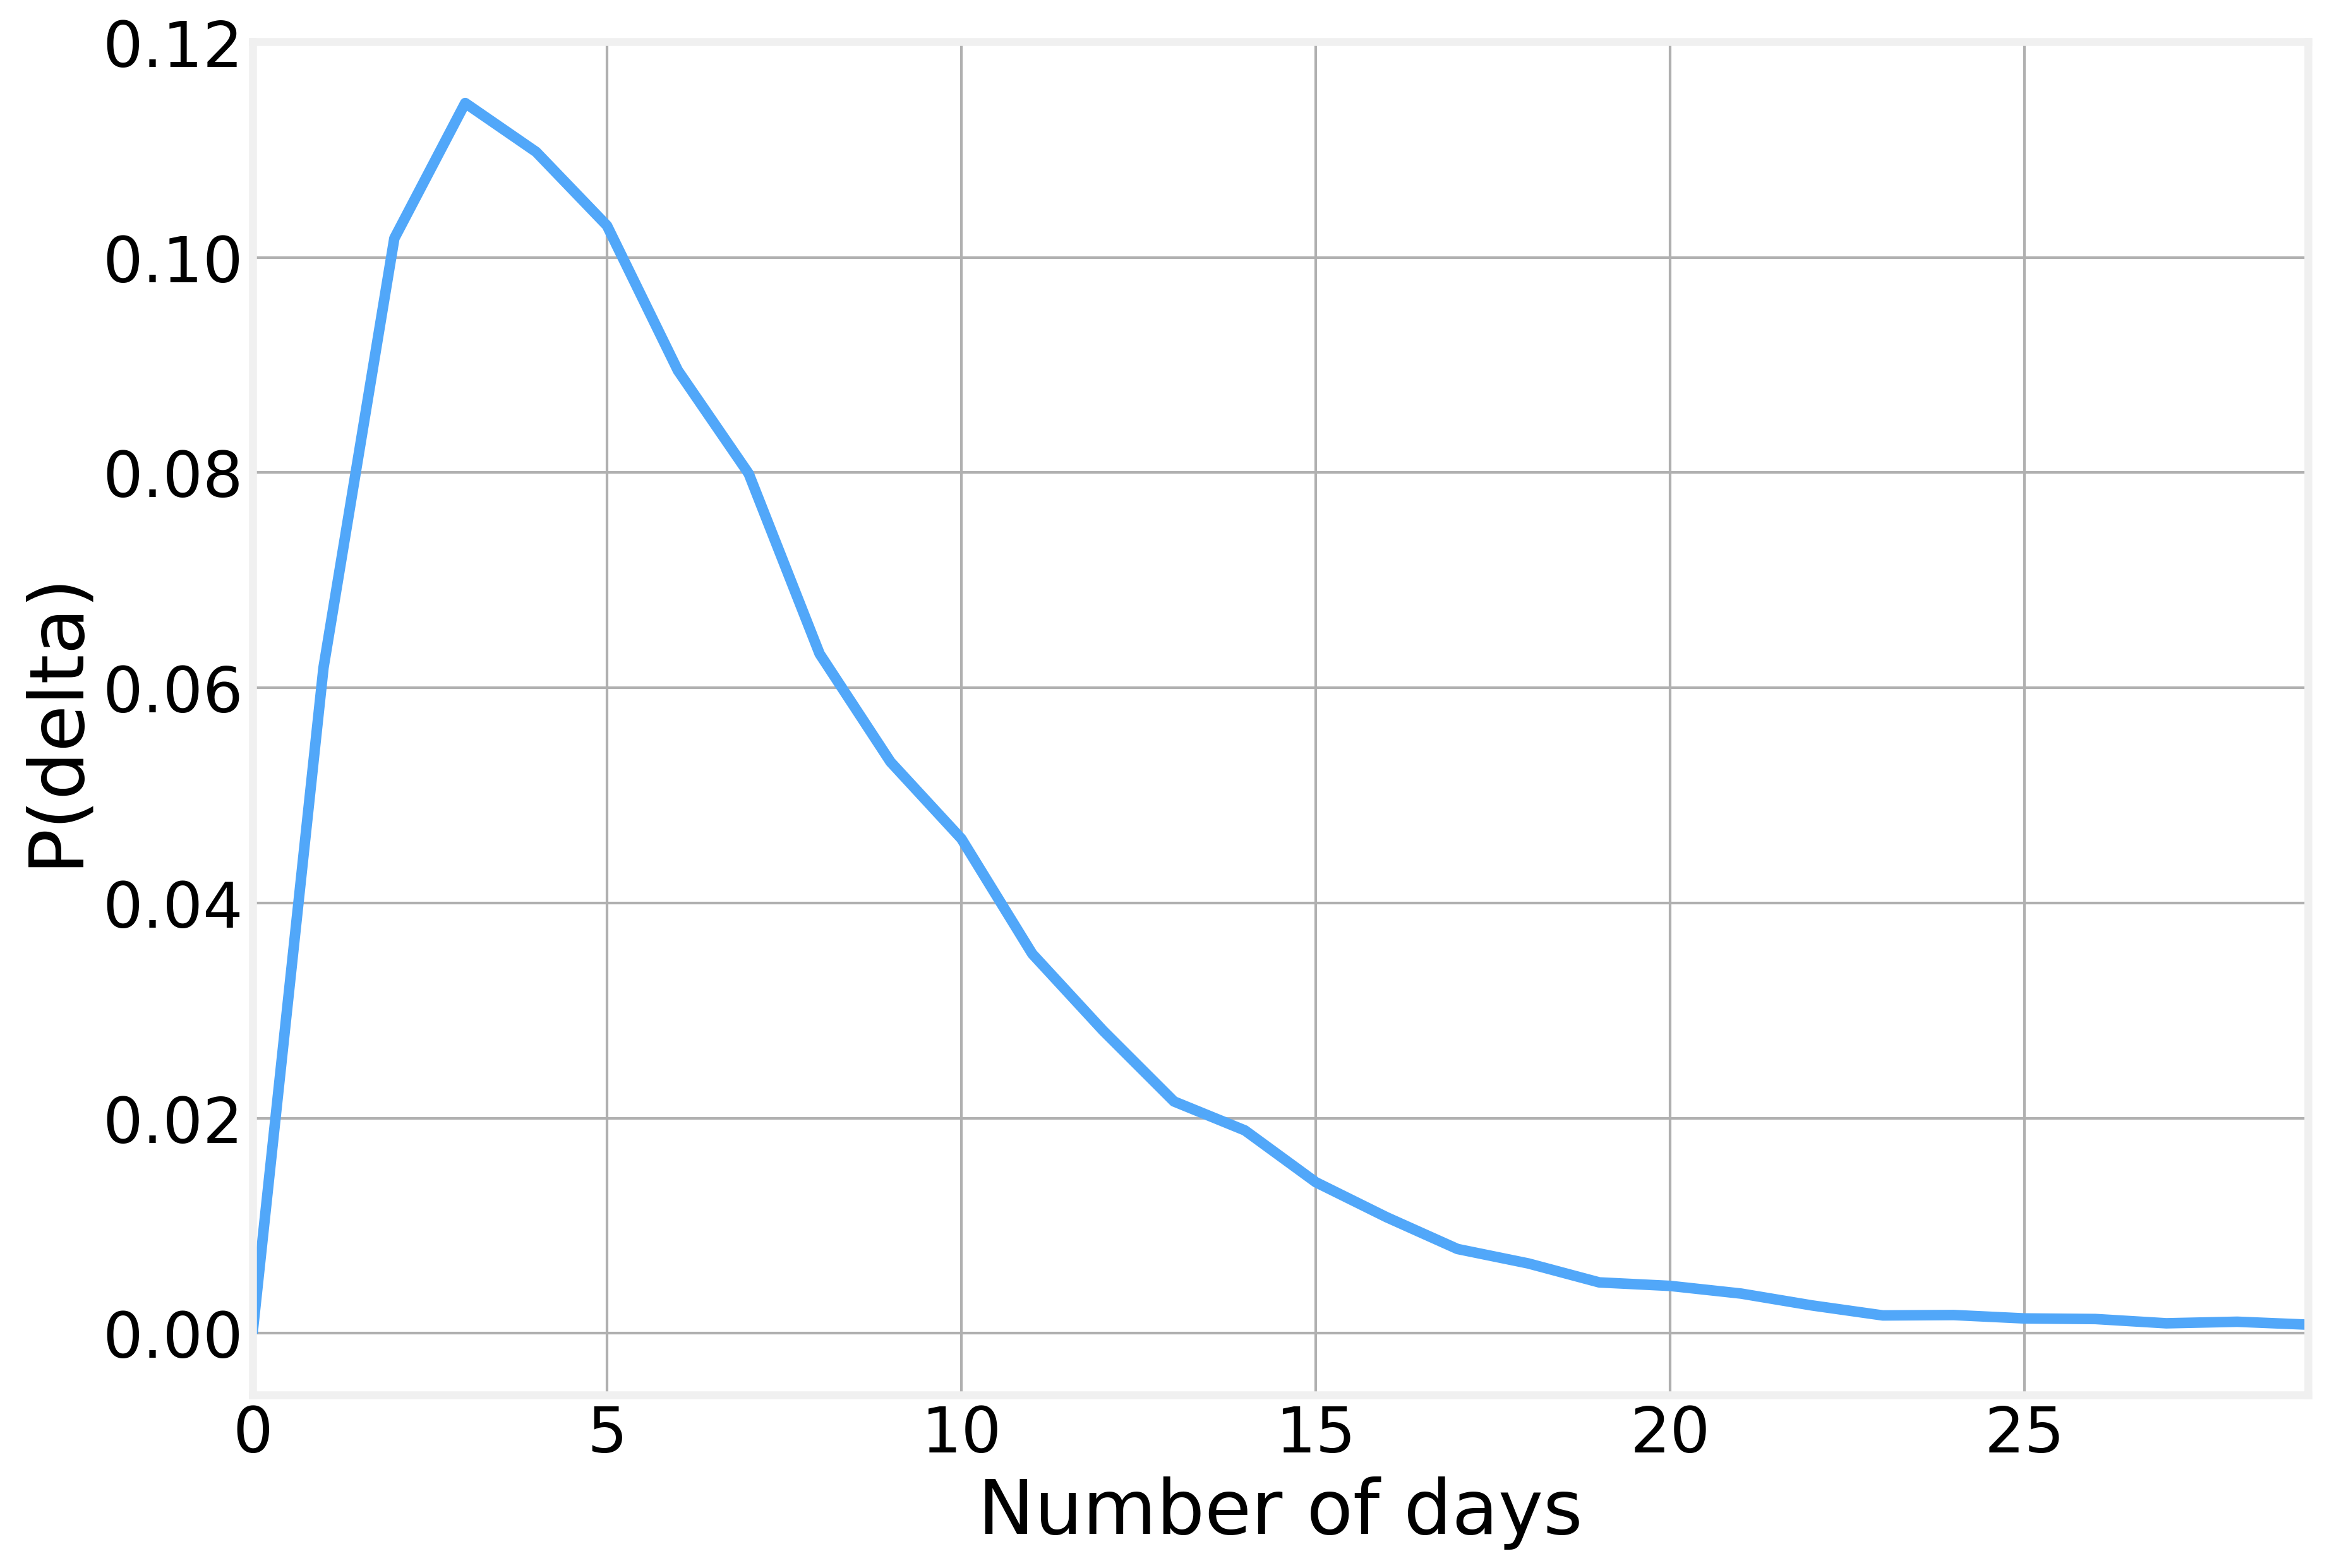

In [33]:
fig, ax = plt.subplots(1)

ax.plot(germany_delay.index, germany_delay)
ax.set_ylabel('P(delta)')
ax.set_xlabel('Number of days')
ax.set_xlim(0, 29)
fig.tight_layout()

## Convert confirmed cases to onset dates

Inspired by https://github.com/k-sys/covid-19

Get the official number of confirmed cases form the JHU dataset

In [34]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
confirmed = pd.read_csv(url + 'time_series_covid19_confirmed_global.csv')

In [35]:
del_columns = [
 'Province/State',
 'Lat',
 'Long',
]

In [36]:
confirmed_timeline = confirmed.drop(columns=del_columns).groupby('Country/Region').sum().T
confirmed_timeline.index = pd.to_datetime(confirmed_timeline.index)

Extract the values for Germany

In [37]:
germany_confirmed = confirmed_timeline['Germany'].diff(1).dropna()

Convolve the number of confirmed cases with the empirical delay probabilities. We invert the confirmed values in order to convolve into the past

In [38]:
germany_convolved = np.convolve(germany_confirmed[::-1].values, germany_delay['counts'])

Manually calculate the new index dates

In [39]:
new_dates = pd.date_range(end=germany_confirmed.index.max(), periods=len(germany_convolved))
germany_onset = pd.Series(np.flip(germany_convolved), index=new_dates)

Compare the results

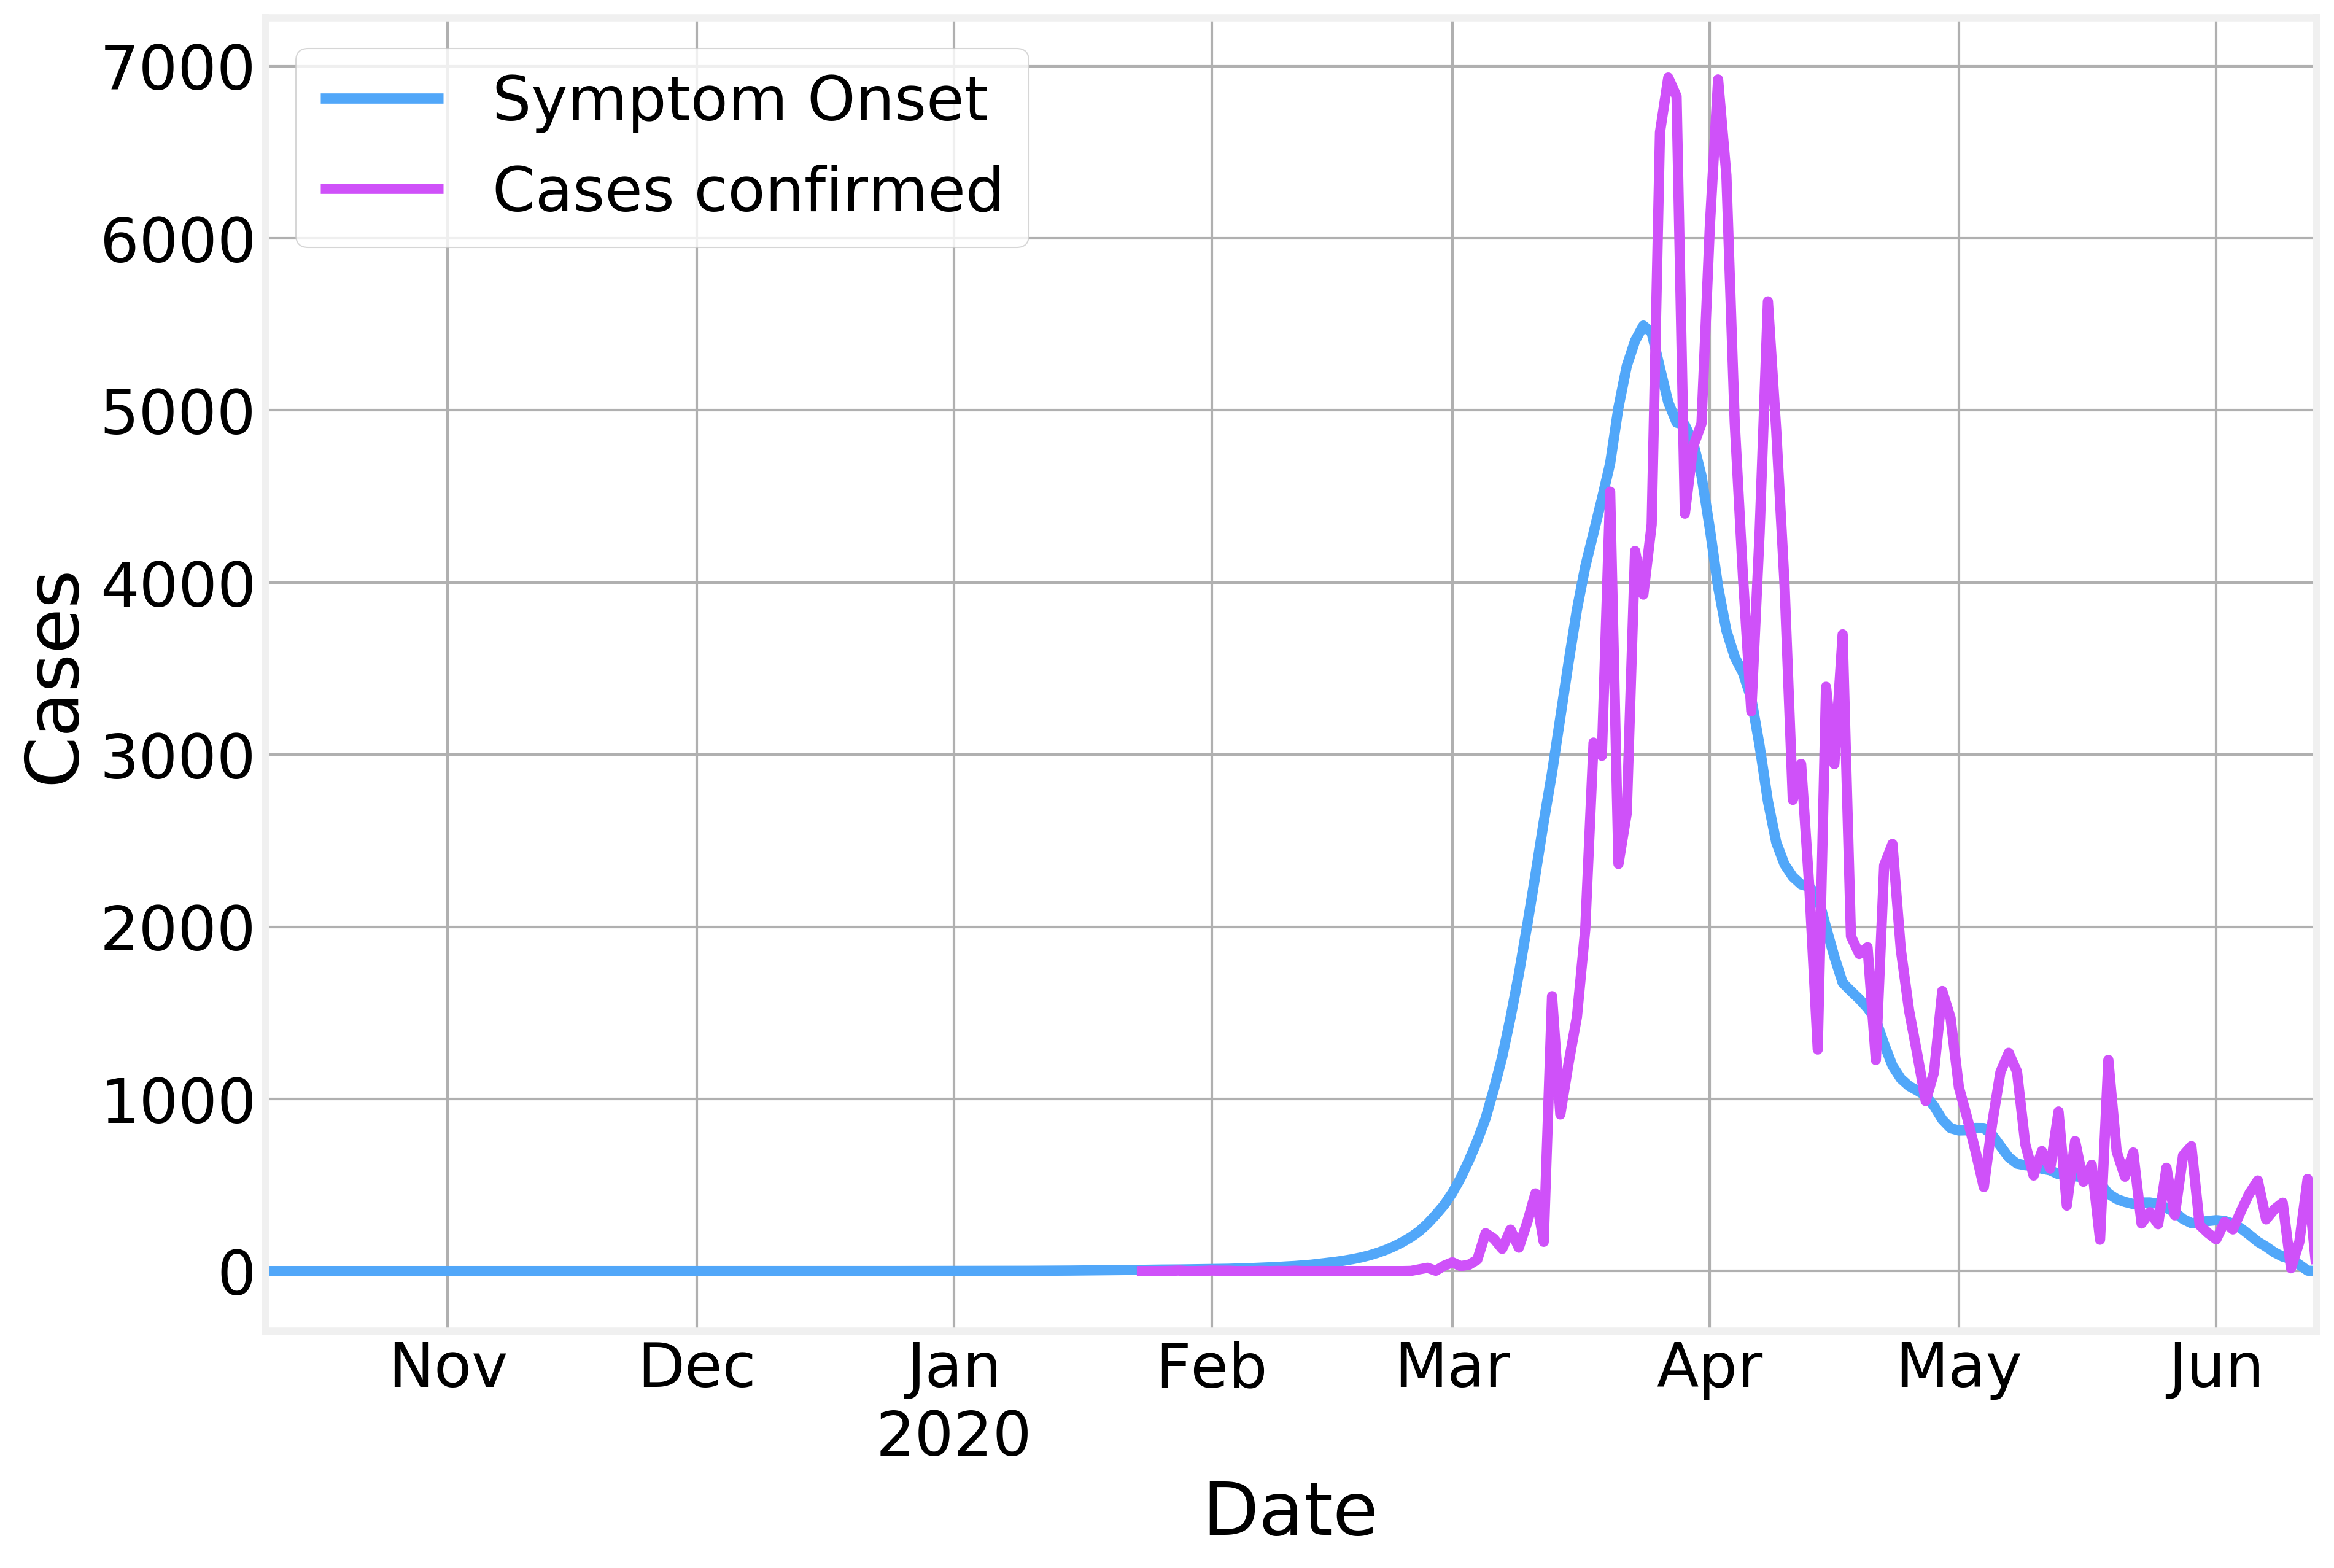

In [40]:
ax = germany_onset.plot(label='Symptom Onset')
germany_confirmed.plot(ax=ax, label='Cases confirmed')
ax.set_xlabel('Date')
ax.set_ylabel('Cases')
ax.legend()

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>